In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Let's try to do our best with a few ML model

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD


Using TensorFlow backend.


In [4]:
sklearn.__version__

'0.20.2'

In [5]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.model_selection import KFold

## Data Preparation

In [6]:
from transplant.data.learningset import Learningset
#from transplant.config import *
learningset = Learningset()

#X_train, X_test, y_train, y_test, X_col = learningset.get_static_filled(to_train=True)
#X_train, X_test, y_train, y_test, X_col = learningset.get_data_merged_dynamic_flatten_full("cls", False)
#X_train, X_test, y_train, y_test, X_col = armand_funct()

train, test = learningset.get_data_merged_dynamic_flatten_full(full_df=True)

Choix des features : 

In [7]:
## RFE avec 4 modèles d'ensemble
choix_features_1=['PEEPtotal_std',
 'Temp_mean',
 'ETCO2_mean',
 'FiO2_std',
 'LAS',
 'Poids',
 'SpO2_mean',
 'BIS SR_std']

## Variables Antoine avec perspective résultats RFE
choix_features_4=['FiO2_std','FiO2_mean',
                  'SpO2_mean','SpO2_std',
                  'PEEPtotal_mean',
                  'BIS SR_std',
                  'PAPsys_max','PAPsys_std',
                  'PASs_mean','PASm_max',
                  'LAS',
                  'FC_std'
                 ]

choix_features_5=set(choix_features_4 + choix_features_1)


choix_features_6=['B.I.S_std',
 'ETCO2_max',
 'ETCO2_mean',
 'FC_mean',
 'FR_max',
 'FR_mean',
 'FiO2_mean',
 'FiO2_std',
 'LAS',
 'PAPmoy_mean',
 'PAPsys_max',
 'PASd_mean',
 'PASs_mean',
 'PEEPtotal_mean',
 'PEEPtotal_std',
 'PF_donor',
 'Poids',
 'SpO2_std',
 'Temp_mean',
 'VT_max',
 'VT_std',
 'body_mass_index',
 'declampage_cote2_done_std',
 'oto_score']

choix_features_7=set(choix_features_4 + choix_features_6)

choix_features_8=['BMI_donor', 'LAS', 'PF_donor', 'Poids', 'Poids_donor', 'Taille', 'age',
       'body_mass_index', 'oto_score', 'start_operation_month',
       'start_operation_day', 'ends_operation_day', 'ETCO2_mean', 'FC_mean',
       'FR_mean', 'FiO2_mean', 'PAPdia_mean', 'PAPmoy_mean', 'PASd_mean',
       'PASs_mean', 'PEEPtotal_mean', 'PNIm_mean', 'PNIs_mean', 'Pmax_mean',
       'Pmean_mean', 'SpO2_mean', 'Temp_mean', 'VT_mean',
       'declampage_cote2_done_mean', 'B.I.S_std', 'ETCO2_std', 'FC_std',
       'FiO2_std', 'PAPmoy_std', 'PASd_std', 'PASm_std', 'PASs_std',
       'PEEPtotal_std', 'PNIs_std', 'Pmax_std', 'Pmean_std', 'SpO2_std',
       'SvO2 (m)_std', 'Temp_std', 'VT_std', 'declampage_cote2_done_std',
       'ETCO2_max', 'FR_max', 'PAPmoy_max', 'PAPsys_max', 'PASd_max',
       'PASm_max', 'PASs_max', 'PEEPtotal_max', 'PNId_max', 'PNIm_max',
       'Pmax_max', 'Pmean_max', 'Temp_max', 'VT_max']

choix_features_9=set(choix_features_4 + choix_features_8)

choix_features_10=['Poids', 'ends_operation_day', 'ETCO2_mean', 'PASs_mean',
       'PEEPtotal_mean', 'Pmax_mean', 'Pmean_mean', 'SpO2_mean', 'Temp_mean',
       'VT_mean', 'declampage_cote2_done_mean', 'PASd_std', 'VT_std',
       'PASm_max', 'Temp_max']

choix_features_11=set(choix_features_4 + choix_features_10)

In [8]:
Choix_Features=choix_features_4

In [9]:
num_feat=len(Choix_Features)

In [10]:
X_train=train[Choix_Features].values 
X_test=test[Choix_Features].values
y_train=train['target'].values
y_test=test['target'].values

In [11]:
X_col=train[Choix_Features].columns

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228, 12), (102, 12), (228,), (102,))

We need to change the y format in order to make our models work

In [13]:
y_train, y_test = y_train.reshape(-1, 1).ravel() , y_test.reshape(-1, 1).ravel()

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228, 12), (102, 12), (228,), (102,))

## Models d'Ensembles

In [15]:
cols = X_col  # On a besoin des colonnes pour plus tard
# On observe le grand X et pas le petit x ...

ntrain = X_train.shape[0]

ntest = X_test.shape[0]

seed = 5                   # Pour reproduire les résultats

In [16]:
ntrain, ntest

(228, 102)

In [17]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [18]:
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=seed)


def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [19]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

In [20]:
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [21]:
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

In [22]:
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [23]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier,
                   seed=seed, params=gb_params)

In [24]:
X_train.shape, y_train.shape, X_test.shape

((228, 12), (228,), (102, 12))

### Ensemble Learning zone

In [25]:
%%time
np.random.seed(seed)
et_oof_train, et_oof_test = get_oof(
    et, X_train, y_train, X_test)  # Extra Trees
rf_oof_train, rf_oof_test = get_oof(
    rf, X_train, y_train, X_test)  # Random Forest
ada_oof_train, ada_oof_test = get_oof(
    ada, X_train, y_train, X_test)  # AdaBoost
gb_oof_train, gb_oof_test = get_oof(
    gb, X_train, y_train, X_test)  # Gradient Boost

print("I am done learning :D")

I am done learning :D
Wall time: 27 s


In [26]:
rf_feature = rf.feature_importances(X_train, y_train)
et_feature = et.feature_importances(X_train, y_train)
ada_feature = ada.feature_importances(X_train, y_train)
gb_feature = gb.feature_importances(X_train, y_train)

# On met plutot dans un dataFrame
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest Importance des features': rf_feature,
                                  'Extra Trees Importance des features': et_feature,
                                  'AdaBoost Importance des features': ada_feature,
                                  'Gradient Boost Importance des features': gb_feature
                                  })

In [27]:
rf_pred = rf.predict(X_test)
et_pred = et.predict(X_test)
ada_pred = ada.predict(X_test)
gb_pred = gb.predict(X_test)

In [28]:
accu_comparaison={} ## To compare performances at the end
accu_comparaison_train={}

## Résultats

#### For the ones who forgot : 

##### Compute the precision

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

##### Compute the recall

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

##### F1 score
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

The support is the number of occurrences of each class in y_true

### Random Forest

In [29]:
print("Accuracy :")
rf_accu=metrics.accuracy_score(y_test,rf_pred)
accu_comparaison['Random Forest']=rf_accu
accu_comparaison_train['Random Forest']=metrics.accuracy_score(y_train,rf_oof_train)
print(rf_accu)

Accuracy :
0.6764705882352942


In [30]:
accu_comparaison

{'Random Forest': 0.6764705882352942}

In [31]:
print(metrics.classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        62
           1       0.58      0.62      0.60        40

   micro avg       0.68      0.68      0.68       102
   macro avg       0.66      0.67      0.66       102
weighted avg       0.68      0.68      0.68       102



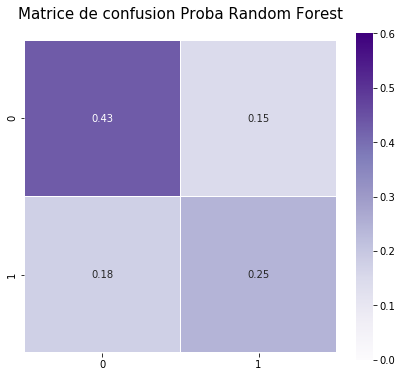

In [32]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Random Forest', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, rf_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

### Extra Tree

In [33]:
print("Accuracy :")
et_accu=metrics.accuracy_score(y_test,et_pred)
accu_comparaison['Extra Tree']=et_accu
accu_comparaison_train['Extra Tree']=metrics.accuracy_score(y_train,et_oof_train)
print(et_accu)

Accuracy :
0.6666666666666666


In [34]:
print(metrics.classification_report(et_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        75
           1       0.42      0.67      0.51        27

   micro avg       0.67      0.67      0.67       102
   macro avg       0.63      0.67      0.63       102
weighted avg       0.73      0.67      0.68       102



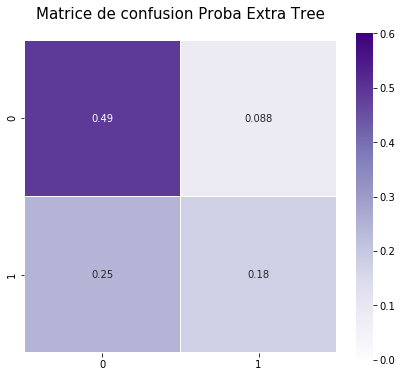

In [35]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Extra Tree', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, et_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

### Ada Boost

In [36]:
print("Accuracy :")
ada_accu=metrics.accuracy_score(y_test,ada_pred)
accu_comparaison['Ada Boost']=ada_accu
accu_comparaison_train['Ada Boost']=metrics.accuracy_score(y_train,ada_oof_train)
print(ada_accu)

Accuracy :
0.5686274509803921


In [37]:
print(metrics.classification_report(ada_pred, y_test))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61        55
           1       0.53      0.49      0.51        47

   micro avg       0.57      0.57      0.57       102
   macro avg       0.56      0.56      0.56       102
weighted avg       0.57      0.57      0.57       102



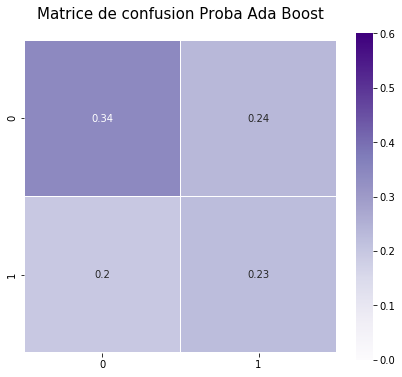

In [38]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Ada Boost', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, ada_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

### Gradient Boost

In [39]:
print("Accuracy :")
gb_accu=metrics.accuracy_score(y_test,gb_pred)
accu_comparaison['Gradient Boost']=gb_accu
accu_comparaison_train['Gradient Boost']=metrics.accuracy_score(y_train,gb_oof_train)
print(gb_accu)

Accuracy :
0.6274509803921569


In [40]:
print(metrics.classification_report(gb_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        59
           1       0.56      0.56      0.56        43

   micro avg       0.63      0.63      0.63       102
   macro avg       0.62      0.62      0.62       102
weighted avg       0.63      0.63      0.63       102



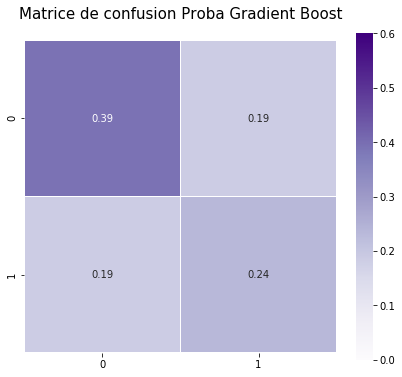

In [41]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Gradient Boost', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, gb_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

## Réseaux de Neuronnes 

In [42]:
from sklearn.preprocessing import StandardScaler

reduire_centrer=True


if reduire_centrer :
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)

In [43]:
model = Sequential()
model.add(Dense(num_feat//2, input_dim=num_feat, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5)) #Très efficacee contre overfitting 
model.add(Dense(num_feat//8,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [44]:
np.random.seed(seed)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=5,
          verbose=0)

score = model.evaluate(X_test, y_test, batch_size=50)

102/102 [==============================] - 0s 784us/step


In [45]:
dl_y_train_pred=(model.predict(X_train)>0.5)*1
dl_y_test_pred=(model.predict(X_test)>0.5)*1

In [46]:
print("Accuracy :")
nn_accu=score[1]
accu_comparaison['Neural Network']=nn_accu
accu_comparaison_train['Neural Network']=metrics.accuracy_score(y_train,dl_y_train_pred)
print(nn_accu)

Accuracy :
0.5784313707959419


In [47]:
print(metrics.classification_report(y_test,dl_y_test_pred))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73        59
           1       0.00      0.00      0.00        43

   micro avg       0.58      0.58      0.58       102
   macro avg       0.29      0.50      0.37       102
weighted avg       0.33      0.58      0.42       102



C:\Users\Delanoue\Anaconda3\envs\env_py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Delanoue\Anaconda3\envs\env_py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Delanoue\Anaconda3\envs\env_py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



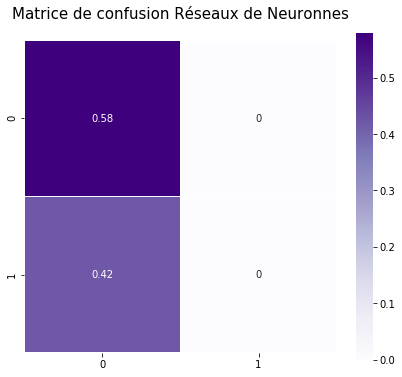

In [48]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Réseaux de Neuronnes', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test,dl_y_test_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## SVM 

In [49]:
from sklearn.svm import SVC
SVC_clf = SVC(gamma='auto')
SVC_clf.fit(X_train, y_train)


svc_pred=SVC_clf.predict(X_test)
svc_y_train_pred=SVC_clf.predict(X_train)

In [50]:
print("Accuracy :")
svc_accu=metrics.accuracy_score(y_test,svc_pred)
accu_comparaison['SVM']=svc_accu
accu_comparaison_train['SVM']=metrics.accuracy_score(y_train,svc_y_train_pred)
print(svc_accu)

Accuracy :
0.6274509803921569


In [51]:
print(metrics.classification_report(svc_pred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70        67
           1       0.47      0.57      0.51        35

   micro avg       0.63      0.63      0.63       102
   macro avg       0.61      0.61      0.61       102
weighted avg       0.65      0.63      0.63       102



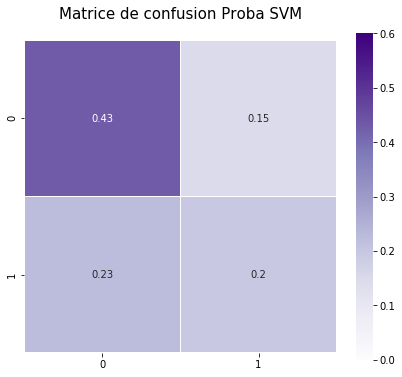

In [52]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba SVM', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, svc_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

## Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

logreg_clf=LogisticRegression()
logreg_clf.fit(X_train,y_train)

logreg_pred=logreg_clf.predict(X_test)
logreg_y_train_pred=logreg_clf.predict(X_train)

In [54]:
print("Accuracy :")
logreg_accu=metrics.accuracy_score(y_test,logreg_pred)
accu_comparaison['Logistic Regression']=logreg_accu
accu_comparaison_train['Logistic Regression']=metrics.accuracy_score(y_train,logreg_y_train_pred)
print(logreg_accu)

Accuracy :
0.5784313725490197


In [55]:
print(metrics.classification_report(logreg_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        64
           1       0.44      0.50      0.47        38

   micro avg       0.58      0.58      0.58       102
   macro avg       0.56      0.56      0.56       102
weighted avg       0.59      0.58      0.58       102



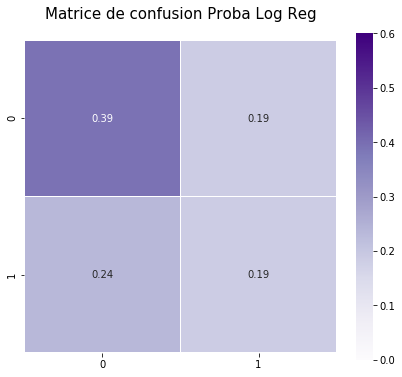

In [56]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Log Reg', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, logreg_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

## Stacking 

 ### Prédictions des différents modèles 

In [57]:
premieres_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
     'Neural Network' : dl_y_train_pred.ravel(),
                      'SVM':     svc_y_train_pred.ravel()  ,
                                             'Logistic Regression':logreg_y_train_pred.ravel()
    }).astype(int)
premieres_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,Neural Network,SVM,Logistic Regression
0,0,1,0,0,0,0,0
1,0,1,1,0,0,1,1
2,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0


In [58]:
premieres_predictions_test = pd.DataFrame( {'RandomForest': rf_oof_test.ravel(),
                                             'ExtraTrees': et_oof_test.ravel(),
                                             'AdaBoost': ada_oof_test.ravel(),
                                              'GradientBoost': gb_oof_test.ravel(),
                                             'Neural Network' : dl_y_test_pred.ravel(),
                                             'SVM':     svc_pred.ravel()  ,
                                             'Logistic Regression':logreg_pred.ravel()
    }).astype(int)
premieres_predictions_test.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,Neural Network,SVM,Logistic Regression
0,1,0,1,0,0,0,0
1,1,1,1,1,0,1,1
2,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0


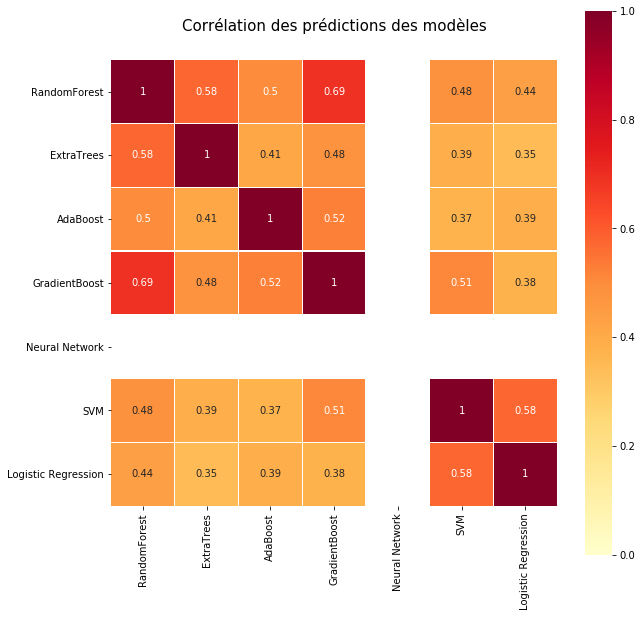

In [59]:
colormap = plt.cm.YlOrRd
plt.figure(figsize=(10,10))
plt.title('Corrélation des prédictions des modèles', y=1.05, size=15)
sns.heatmap(premieres_predictions_train.astype(float).corr().values, linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=1,
           xticklabels=premieres_predictions_train.columns.values, yticklabels=premieres_predictions_train.columns.values)

In [60]:
accu_train_comparaison_df=pd.DataFrame(accu_comparaison_train,index=[0])

index_asc_train=accu_train_comparaison_df.values.ravel().argsort().argsort()
index_asc_train

array([3, 0, 5, 2, 1, 6, 4], dtype=int64)

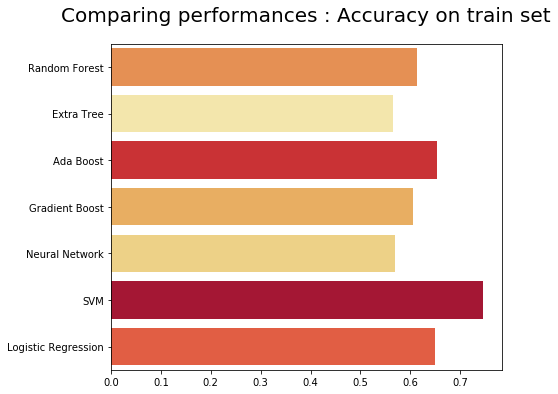

In [61]:
plt.figure(figsize=(7,6))
plt.title('Comparing performances : Accuracy on train set', y=1.05, size=20)
sns.barplot(accu_train_comparaison_df.values.ravel(),
            accu_train_comparaison_df.columns,
            palette=np.array((sns.color_palette("YlOrRd", n_colors=len(index_asc_train))))[list(index_asc_train)])

In [62]:
accu_train_comparaison_df

,Random Forest,Extra Tree,Ada Boost,Gradient Boost,Neural Network,SVM,Logistic Regression
0,0.614035,0.565789,0.653509,0.605263,0.570175,0.745614,0.649123


In [63]:
Choix_Stacking=['RandomForest','ExtraTrees','AdaBoost','GradientBoost']

In [64]:
x_stack_train =premieres_predictions_train[Choix_Stacking].values
x_stack_test = premieres_predictions_test[Choix_Stacking].values

### GradientBoosting Stack

In [65]:
GBC_stck=GradientBoostingClassifier()

In [66]:
GBC_stck.fit(x_stack_train,y_train)
y_test_GBC_stack=GBC_stck.predict(x_stack_test)

In [67]:
GBC_stck.feature_importances_

array([0.07649079, 0.10705214, 0.70663434, 0.10982274])

In [68]:
print("Accuracy :")
GBC_stack_accu=metrics.accuracy_score(y_test,y_test_GBC_stack)
accu_comparaison['Gradient Boosting Stacked']=GBC_stack_accu
print(GBC_stack_accu)

Accuracy :
0.6862745098039216


In [69]:
print(metrics.classification_report(y_test,y_test_GBC_stack))

              precision    recall  f1-score   support

           0       0.68      0.88      0.76        59
           1       0.72      0.42      0.53        43

   micro avg       0.69      0.69      0.69       102
   macro avg       0.70      0.65      0.65       102
weighted avg       0.69      0.69      0.67       102



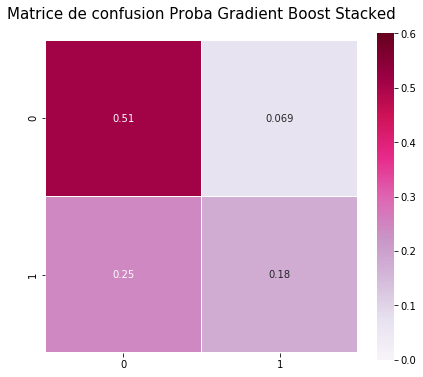

In [70]:
colormap = plt.cm.PuRd
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Gradient Boost Stacked', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test,y_test_GBC_stack)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

### Random Forest Stack

In [71]:
RF_stck=RandomForestClassifier()

In [72]:
RF_stck.fit(x_stack_train,y_train)
y_test_RF_stack=RF_stck.predict(x_stack_test)

In [73]:
RF_stck.feature_importances_

array([0.21931412, 0.20629733, 0.42478048, 0.14960807])

In [74]:
print("Accuracy :")
RF_stack_accu=metrics.accuracy_score(y_test,y_test_RF_stack)
accu_comparaison['Random Forest Stacked']=RF_stack_accu
print(RF_stack_accu)

Accuracy :
0.6862745098039216


In [75]:
print(metrics.classification_report(y_test,y_test_RF_stack))

              precision    recall  f1-score   support

           0       0.68      0.88      0.76        59
           1       0.72      0.42      0.53        43

   micro avg       0.69      0.69      0.69       102
   macro avg       0.70      0.65      0.65       102
weighted avg       0.69      0.69      0.67       102



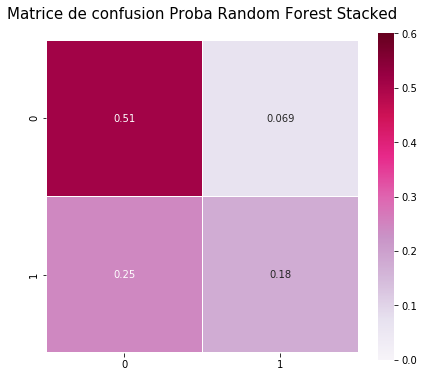

In [76]:
colormap = plt.cm.PuRd
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Random Forest Stacked', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test,y_test_RF_stack)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

## Comparaison Résultats

In [77]:
accu_comparaison

{'Random Forest': 0.6764705882352942,
 'Extra Tree': 0.6666666666666666,
 'Ada Boost': 0.5686274509803921,
 'Gradient Boost': 0.6274509803921569,
 'Neural Network': 0.5784313707959419,
 'SVM': 0.6274509803921569,
 'Logistic Regression': 0.5784313725490197,
 'Gradient Boosting Stacked': 0.6862745098039216,
 'Random Forest Stacked': 0.6862745098039216}

In [78]:
accu_comparaison_df=pd.DataFrame(accu_comparaison,index=[0])

In [79]:
index_asc=accu_comparaison_df.values.ravel().argsort().argsort()
index_asc

array([6, 5, 0, 3, 1, 4, 2, 7, 8], dtype=int64)

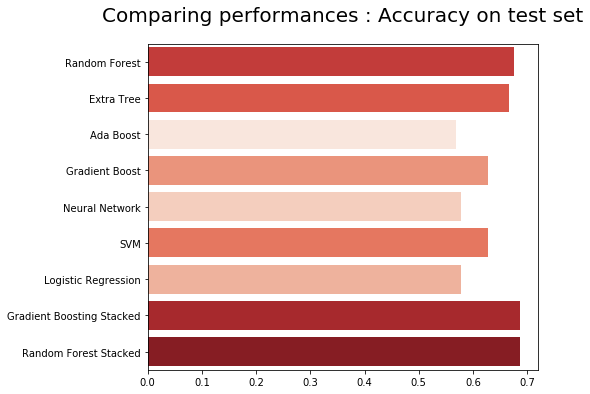

In [80]:
plt.figure(figsize=(7,6))
plt.title('Comparing performances : Accuracy on test set', y=1.05, size=20)
sns.barplot(accu_comparaison_df.values.ravel(),
            accu_comparaison_df.columns,
            palette=np.array((sns.color_palette("Reds", n_colors=len(index_asc))))[list(index_asc)])

In [81]:
accu_comparaison_df

,Random Forest,Extra Tree,Ada Boost,Gradient Boost,Neural Network,SVM,Logistic Regression,Gradient Boosting Stacked,Random Forest Stacked
0,0.676471,0.666667,0.568627,0.627451,0.578431,0.627451,0.578431,0.686275,0.686275
